In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
aqi= pd.read_csv('data.csv',encoding = 'unicode_escape')


In [3]:
aqi.shape

(435742, 13)

In [4]:
aqi.isnull().sum()


stn_code                       144077
sampling_date                       3
state                               0
location                            3
agency                         149481
type                             5393
so2                             34646
no2                             16233
rspm                            40222
spm                            237387
location_monitoring_station     27491
pm2_5                          426428
date                                7
dtype: int64

In [5]:
aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
stn_code                       291665 non-null object
sampling_date                  435739 non-null object
state                          435742 non-null object
location                       435739 non-null object
agency                         286261 non-null object
type                           430349 non-null object
so2                            401096 non-null float64
no2                            419509 non-null float64
rspm                           395520 non-null float64
spm                            198355 non-null float64
location_monitoring_station    408251 non-null object
pm2_5                          9314 non-null float64
date                           435735 non-null object
dtypes: float64(5), object(8)
memory usage: 43.2+ MB


In [6]:
aqi.drop(['stn_code', 'agency', 'sampling_date', 'location_monitoring_station'], axis=1, inplace=True)

In [7]:
aqi = aqi.dropna(subset=['date'])

In [8]:
aqi.state = aqi.state.replace({'Uttaranchal':'Uttarakhand'})
aqi.state[aqi.location == "Jamshedpur"] = aqi.state[aqi.location == 'Jamshedpur'].replace({"Bihar":"Jharkhand"})

In [9]:
types = {
    "Residential": "R",
    "Residential and others": "RO",
    "Residential, Rural and other Areas": "RRO",
    "Industrial Area": "I",
    "Industrial Areas": "I",
    "Industrial": "I",
    "Sensitive Area": "S",
    "Sensitive Areas": "S",
    "Sensitive": "S",
    np.nan: "RRO"
}

In [10]:
aqi.type = aqi.type.replace(types)

In [11]:
aqi.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,RRO,4.8,17.4,NaN,NaN,NaN,1990-02-01
1,Andhra Pradesh,Hyderabad,I,3.1,7.0,NaN,NaN,NaN,1990-02-01
2,Andhra Pradesh,Hyderabad,RRO,6.2,28.5,NaN,NaN,NaN,1990-02-01
3,Andhra Pradesh,Hyderabad,RRO,6.3,14.7,NaN,NaN,NaN,1990-03-01
4,Andhra Pradesh,Hyderabad,I,4.7,7.5,NaN,NaN,NaN,1990-03-01


In [12]:
VALUE_COLS = ['so2', 'no2', 'rspm', 'spm', 'pm2_5']
VALUE_COLS

['so2', 'no2', 'rspm', 'spm', 'pm2_5']

In [13]:
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values=np.nan, strategy='mean')
aqi[VALUE_COLS]=imputer.fit_transform(aqi[VALUE_COLS])


In [14]:

aqi.isnull().sum()

state       0
location    0
type        0
so2         0
no2         0
rspm        0
spm         0
pm2_5       0
date        0
dtype: int64

In [15]:
aqi.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date
0,Andhra Pradesh,Hyderabad,RRO,4.8,17.4,108.833091,220.78348,40.791467,1990-02-01
1,Andhra Pradesh,Hyderabad,I,3.1,7.0,108.833091,220.78348,40.791467,1990-02-01
2,Andhra Pradesh,Hyderabad,RRO,6.2,28.5,108.833091,220.78348,40.791467,1990-02-01
3,Andhra Pradesh,Hyderabad,RRO,6.3,14.7,108.833091,220.78348,40.791467,1990-03-01
4,Andhra Pradesh,Hyderabad,I,4.7,7.5,108.833091,220.78348,40.791467,1990-03-01


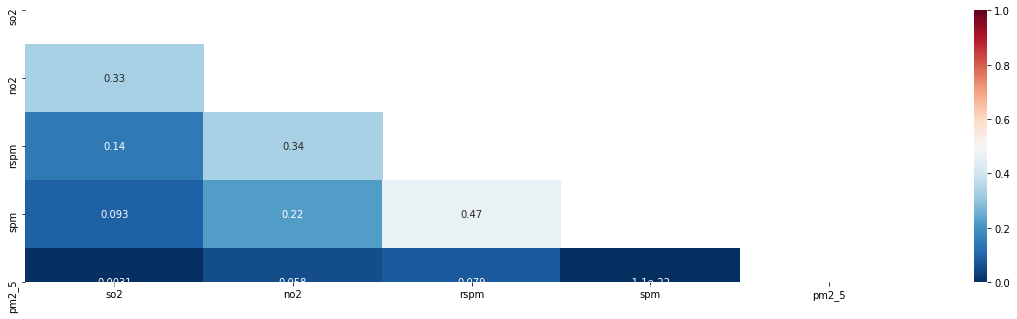

In [16]:
plt.figure(figsize=(20,5))
mask = np.zeros_like(aqi.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(aqi.corr(),cmap='RdBu_r',mask=mask, annot=True)

In [17]:
def calculate_si(so2):
    si=0
    if (so2<=40):
     si= so2*(50/40)
    if (so2>40 and so2<=80):
     si= 50+(so2-40)*(50/40)
    if (so2>80 and so2<=380):
     si= 100+(so2-80)*(100/300)
    if (so2>380 and so2<=800):
     si= 200+(so2-380)*(100/800)
    if (so2>800 and so2<=1600):
     si= 300+(so2-800)*(100/800)
    if (so2>1600):
     si= 400+(so2-1600)*(100/800)
    return si


In [18]:
aqi['si']=aqi['so2'].apply(calculate_si)
df= aqi[['so2','si']]
df.head()

,so2,si
0,4.8,6.000
1,3.1,3.875
2,6.2,7.750
3,6.3,7.875
4,4.7,5.875


In [19]:
#Function to calculate no2 individual pollutant index(ni)
def calculate_ni(no2):
    ni=0
    if(no2<=40):
     ni= no2*50/40
    elif(no2>40 and no2<=80):
     ni= 50+(no2-14)*(50/40)
    elif(no2>80 and no2<=180):
     ni= 100+(no2-80)*(100/100)
    elif(no2>180 and no2<=280):
     ni= 200+(no2-180)*(100/100)
    elif(no2>280 and no2<=400):
     ni= 300+(no2-280)*(100/120)
    else:
     ni= 400+(no2-400)*(100/120)
    return ni
aqi['ni']=aqi['no2'].apply(calculate_ni)
df= aqi[['no2','ni']]
df.head()

,no2,ni
0,17.4,21.750
1,7.0,8.750
2,28.5,35.625
3,14.7,18.375
4,7.5,9.375


In [20]:
def calculate_rpi(rspm):
    rpi=0
    if(rpi<=30):
     rpi=rpi*50/30
    elif(rpi>30 and rpi<=60):
     rpi=50+(rpi-30)*50/30
    elif(rpi>60 and rpi<=90):
     rpi=100+(rpi-60)*100/30
    elif(rpi>90 and rpi<=120):
     rpi=200+(rpi-90)*100/30
    elif(rpi>120 and rpi<=250):
     rpi=300+(rpi-120)*(100/130)
    else:
     rpi=400+(rpi-250)*(100/130)
    return rpi
aqi['rpi']=aqi['rspm'].apply(calculate_rpi)
df= aqi[['rspm','rpi']]
df.tail()
#many data values of rspm values is unawailable since it was not measure before

,rspm,rpi
435734,148.0,0.0
435735,131.0,0.0
435736,140.0,0.0
435737,143.0,0.0
435738,171.0,0.0


In [21]:
def calculate_spi(spm):
    spi=0
    if(spm<=50):
     spi=spm
    if(spm<50 and spm<=100):
     spi=spm
    elif(spm>100 and spm<=250):
     spi= 100+(spm-100)*(100/150)
    elif(spm>250 and spm<=350):
     spi=200+(spm-250)
    elif(spm>350 and spm<=450):
     spi=300+(spm-350)*(100/80)
    else:
     spi=400+(spm-430)*(100/80)
    return spi
aqi['spi']=aqi['spm'].apply(calculate_spi)
df= aqi[['spm','spi']]
df.tail()

,spm,spi
435734,220.78348,180.52232
435735,220.78348,180.52232
435736,220.78348,180.52232
435737,220.78348,180.52232
435738,220.78348,180.52232


In [22]:
aqi.head()

,state,location,type,so2,no2,rspm,spm,pm2_5,date,si,ni,rpi,spi
0,Andhra Pradesh,Hyderabad,RRO,4.8,17.4,108.833091,220.78348,40.791467,1990-02-01,6.000,21.750,0.0,180.52232
1,Andhra Pradesh,Hyderabad,I,3.1,7.0,108.833091,220.78348,40.791467,1990-02-01,3.875,8.750,0.0,180.52232
2,Andhra Pradesh,Hyderabad,RRO,6.2,28.5,108.833091,220.78348,40.791467,1990-02-01,7.750,35.625,0.0,180.52232
3,Andhra Pradesh,Hyderabad,RRO,6.3,14.7,108.833091,220.78348,40.791467,1990-03-01,7.875,18.375,0.0,180.52232
4,Andhra Pradesh,Hyderabad,I,4.7,7.5,108.833091,220.78348,40.791467,1990-03-01,5.875,9.375,0.0,180.52232


In [23]:
#function to calculate the air quality index (AQI) of every data value
#its is calculated as per indian govt standards
def calculate_aqi(si,ni,spi,rpi):
    aqi=0
    if(si>ni and si>spi and si>rpi):
     aqi=si
    if(spi>si and spi>ni and spi>rpi):
     aqi=spi
    if(ni>si and ni>spi and ni>rpi):
     aqi=ni
    if(rpi>si and rpi>ni and rpi>spi):
     aqi=rpi
    return aqi
aqi['AQI']=aqi.apply(lambda aqi:calculate_aqi(aqi['si'],aqi['ni'],aqi['spi'],aqi['rpi']),axis=1)
df= aqi[['date','state','si','ni','rpi','spi','AQI']]
df.tail(20)

,date,state,si,ni,rpi,spi,AQI
435719,2015-10-23,West Bengal,22.50,91.25,0.0,180.52232,180.52232
435720,2015-10-28,West Bengal,23.75,88.75,0.0,180.52232,180.52232
435721,2015-10-31,West Bengal,13.75,42.50,0.0,180.52232,180.52232
435722,2015-11-05,West Bengal,20.00,50.00,0.0,180.52232,180.52232
435723,2015-11-07,West Bengal,18.75,46.25,0.0,180.52232,180.52232
435724,2015-11-10,West Bengal,27.50,116.25,0.0,180.52232,180.52232
435725,2015-11-11,West Bengal,25.00,112.50,0.0,180.52232,180.52232
435726,2015-11-16,West Bengal,17.50,85.00,0.0,180.52232,180.52232
435727,2015-11-20,West Bengal,13.75,42.50,0.0,180.52232,180.52232
435728,2015-11-26,West Bengal,21.25,86.25,0.0,180.52232,180.52232


In [24]:
df.state.unique()

array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Jharkhand', 'Chandigarh', 'Chhattisgarh', 'Dadra & Nagar Haveli',
       'Daman & Diu', 'Delhi', 'Goa', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu & Kashmir', 'Karnataka', 'Kerala',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan',
       'Sikkim', 'Tamil Nadu', 'Telangana', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object)

In [25]:
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
df['year'] = df['date'].dt.year # year
df['year'] = df['year'].fillna(0.0).astype(int)
#data = data[(data['year']>0)]

In [26]:
df.head()

,date,state,si,ni,rpi,spi,AQI,year
0,1990-02-01,Andhra Pradesh,6.000,21.750,0.0,180.52232,180.52232,1990
1,1990-02-01,Andhra Pradesh,3.875,8.750,0.0,180.52232,180.52232,1990
2,1990-02-01,Andhra Pradesh,7.750,35.625,0.0,180.52232,180.52232,1990
3,1990-03-01,Andhra Pradesh,7.875,18.375,0.0,180.52232,180.52232,1990
4,1990-03-01,Andhra Pradesh,5.875,9.375,0.0,180.52232,180.52232,1990


In [27]:
df['state'].value_counts()

Maharashtra             60382
Uttar Pradesh           42816
Andhra Pradesh          26368
Punjab                  25634
Rajasthan               25589
Kerala                  24728
Himachal Pradesh        22896
West Bengal             22463
Gujarat                 21279
Tamil Nadu              20597
Madhya Pradesh          19920
Assam                   19361
Odisha                  19278
Karnataka               17118
Delhi                    8551
Chandigarh               8520
Chhattisgarh             7831
Goa                      6206
Jharkhand                6133
Mizoram                  5338
Telangana                3978
Meghalaya                3853
Puducherry               3785
Haryana                  3420
Nagaland                 2463
Uttarakhand              2246
Bihar                    2110
Jammu & Kashmir          1289
Daman & Diu               782
Dadra & Nagar Haveli      634
Arunachal Pradesh          90
Manipur                    76
Sikkim                      1
Name: stat

In [28]:
df.drop(['date','state'], axis=1, inplace=True)

In [29]:
df.head()

,si,ni,rpi,spi,AQI,year
0,6.000,21.750,0.0,180.52232,180.52232,1990
1,3.875,8.750,0.0,180.52232,180.52232,1990
2,7.750,35.625,0.0,180.52232,180.52232,1990
3,7.875,18.375,0.0,180.52232,180.52232,1990
4,5.875,9.375,0.0,180.52232,180.52232,1990


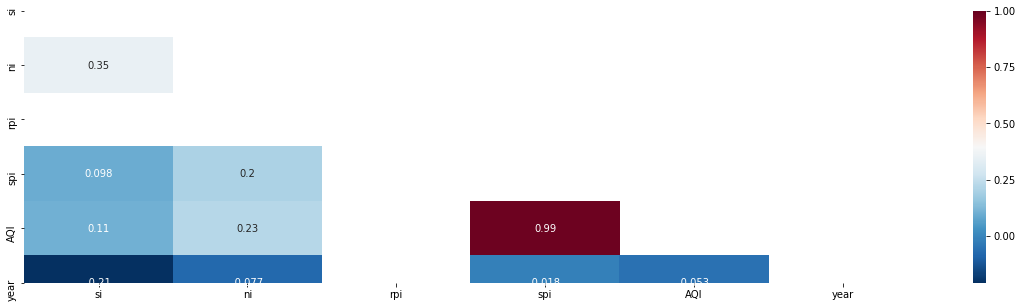

In [30]:
plt.figure(figsize=(20,5))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(),cmap='RdBu_r',mask=mask, annot=True)

In [31]:
X=df.drop(['AQI'],axis=1)
X

,si,ni,rpi,spi,year
0,6.000,21.750,0.0,180.52232,1990
1,3.875,8.750,0.0,180.52232,1990
2,7.750,35.625,0.0,180.52232,1990
3,7.875,18.375,0.0,180.52232,1990
4,5.875,9.375,0.0,180.52232,1990
...,...,...,...,...,...
435734,25.000,87.500,0.0,180.52232,2015
435735,21.250,87.500,0.0,180.52232,2015
435736,22.500,88.750,0.0,180.52232,2015
435737,27.500,95.000,0.0,180.52232,2015


In [32]:
y=df['AQI']
y

0         180.52232
1         180.52232
2         180.52232
3         180.52232
4         180.52232
            ...    
435734    180.52232
435735    180.52232
435736    180.52232
435737    180.52232
435738    180.52232
Name: AQI, Length: 435735, dtype: float64

In [33]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=0)
X_train,X_test,y_train,y_test

(            si      ni  rpi        spi  year
 263847   2.500  13.725  0.0  180.52232  2013
 245888  15.000  40.000  0.0  180.52232  2014
 59947   32.500  39.625  0.0  238.00000  2009
 214413  23.500  48.125  0.0  -27.50000  2008
 244602  17.500  18.750  0.0  180.52232  2014
 ...        ...     ...  ...        ...   ...
 359787  26.250  33.750  0.0  180.52232  2014
 358087  12.500  25.000  0.0  180.52232  2013
 152316   5.000   7.500  0.0  180.52232  2015
 117952   3.750  22.500  0.0  180.52232  2011
 305715  11.625  32.875  0.0  180.52232  2011
 
 [305014 rows x 5 columns],                si          ni  rpi        spi  year
 45127    8.750000   17.500000  0.0  180.52232  2015
 197291  20.750000  102.900000  0.0  350.00000  1990
 385011  13.536784   35.375000  0.0  396.25000  2009
 376139  25.000000   36.250000  0.0  300.00000  2006
 336606  12.500000  105.000000  0.0  180.52232  2012
 ...           ...         ...  ...        ...   ...
 258161  13.536784   32.262074  0.0  -65.00000  

In [34]:
from sklearn.preprocessing import MinMaxScaler
sc_X = MinMaxScaler()
x_train = sc_X.fit_transform(X_train)
x_test = sc_X.transform(X_test)
x_train,x_test

(array([[0.0079713 , 0.01722803, 0.        , 0.08826332, 0.92857143],
        [0.04782782, 0.05020921, 0.        , 0.08826332, 0.96428571],
        [0.10362694, 0.04973849, 0.        , 0.10811744, 0.78571429],
        ...,
        [0.01594261, 0.00941423, 0.        , 0.08826332, 1.        ],
        [0.01195695, 0.02824268, 0.        , 0.08826332, 0.85714286],
        [0.03706656, 0.04126569, 0.        , 0.08826332, 0.85714286]]),
 array([[0.02789956, 0.02196653, 0.        , 0.08826332, 1.        ],
        [0.06616182, 0.12916318, 0.        , 0.14680484, 0.10714286],
        [0.04316233, 0.04440377, 0.        , 0.16278066, 0.78571429],
        ...,
        [0.04982065, 0.0376569 , 0.        , 0.0701209 , 0.82142857],
        [0.05978477, 0.04864017, 0.        , 0.08826332, 0.92857143],
        [0.02471104, 0.04079498, 0.        , 0.01165803, 0.67857143]]))

In [35]:
def RF():
    global New_data,data_test
    global x_train,x_test,y_train,y_test
    
    clf = RandomForestRegressor(n_estimators=50, max_features='sqrt')
    clf = clf.fit(x_train, y_train)
    
    predictions = clf.predict(x_test)
    df_output = pd.DataFrame()
    df_output['AQI'] = df['AQI']
    df_output['AQI Predicted'] = pd.DataFrame(predictions)
    df_output[['AQI','AQI Predicted']].to_csv('AQI@RF.csv',index=False)
    MAE= metrics.mean_absolute_error(y_test,predictions)
    MSE=metrics.mean_squared_error(y_test,predictions)
    RMS= np.sqrt(metrics.mean_squared_error(y_test,predictions))
    r_square = metrics.r2_score(y_test,predictions)
    print('MAE= ', metrics.mean_absolute_error(y_test,predictions))
    print('MSE= ', metrics.mean_squared_error(y_test,predictions))
    print('RMS= ', np.sqrt(metrics.mean_squared_error(y_test,predictions)))
    print('\nr_square:', r_square)
    print("\nPredicted values on the New Data:\n\n",df_output)
    
    
RF()

MAE=  0.5612692308730018
MSE=  94.44962929243738
RMS=  9.718519912642941

r_square: 0.9916932854259409

Predicted values on the New Data:

               AQI  AQI Predicted
0       180.52232      180.52232
1       180.52232      350.28628
2       180.52232      394.70000
3       180.52232      298.44325
4       180.52232      180.52232
...           ...            ...
435734  180.52232            NaN
435735  180.52232            NaN
435736  180.52232            NaN
435737  180.52232            NaN
435738  180.52232            NaN

[435735 rows x 2 columns]


In [36]:
def LR():
    lr = LinearRegression()
    lr = lr.fit(x_train, y_train)
    
    predictions = lr.predict(x_test)
    df_output = pd.DataFrame()
    df_output['AQI'] = df['AQI']
    df_output['AQI Predicted'] = pd.DataFrame(predictions)
    df_output[['AQI','AQI Predicted']].to_csv('AQI@LR.csv',index=False)
    MAE= metrics.mean_absolute_error(y_test,predictions)
    MSE=metrics.mean_squared_error(y_test,predictions)
    RMS= np.sqrt(metrics.mean_squared_error(y_test,predictions))
    r_square = metrics.r2_score(y_test,predictions)
    print('MAE= ', metrics.mean_absolute_error(y_test,predictions))
    print('MSE= ', metrics.mean_squared_error(y_test,predictions))
    print('RMS= ', np.sqrt(metrics.mean_squared_error(y_test,predictions)))
    print('\nr_square:', r_square)
    
    print("\nPredicted values on the New Data:\n\n",df_output)

LR()

MAE=  9.075937512489313
MSE=  272.0661346814904
RMS=  16.49442738264928

r_square: 0.9760721588533795

Predicted values on the New Data:

               AQI  AQI Predicted
0       180.52232     179.962409
1       180.52232     360.661931
2       180.52232     381.769350
3       180.52232     296.293217
4       180.52232     190.181873
...           ...            ...
435734  180.52232            NaN
435735  180.52232            NaN
435736  180.52232            NaN
435737  180.52232            NaN
435738  180.52232            NaN

[435735 rows x 2 columns]


In [37]:
def KNN():
    knn = KNeighborsRegressor()
    knn = lr.fit(x_train, y_train)
    
    predictions = knn.predict(x_test)
    df_output = pd.DataFrame()
    df_output['AQI'] = df['AQI']
    df_output['AQI Predicted'] = pd.DataFrame(predictions)
    df_output[['AQI','AQI Predicted']].to_csv('AQI@KNN.csv',index=False)
    MAE= metrics.mean_absolute_error(y_test,predictions)
    MSE=metrics.mean_squared_error(y_test,predictions)
    RMS= np.sqrt(metrics.mean_squared_error(y_test,predictions))
    r_square = metrics.r2_score(y_test,predictions)
    print('MAE= ', metrics.mean_absolute_error(y_test,predictions))
    print('MSE= ', metrics.mean_squared_error(y_test,predictions))
    print('RMS= ', np.sqrt(metrics.mean_squared_error(y_test,predictions)))
    print('\nr_square:', r_square)
    
    print("\nPredicted values on the New Data:\n\n",df_output)

LR()

MAE=  9.075937512489313
MSE=  272.0661346814904
RMS=  16.49442738264928

r_square: 0.9760721588533795

Predicted values on the New Data:

               AQI  AQI Predicted
0       180.52232     179.962409
1       180.52232     360.661931
2       180.52232     381.769350
3       180.52232     296.293217
4       180.52232     190.181873
...           ...            ...
435734  180.52232            NaN
435735  180.52232            NaN
435736  180.52232            NaN
435737  180.52232            NaN
435738  180.52232            NaN

[435735 rows x 2 columns]


In [38]:
def input_values():
    list=[[0.0079713 , 0.01722803, 0., 0.08826332, 0.92857143]]
    parameters = {'bootstrap': False,
              'min_samples_leaf': 3,
              'n_estimators': 50,
              'min_samples_split': 10,
              'max_features': 'sqrt',
              'max_depth': 6}

    rf = RandomForestRegressor(**parameters)
    rf.fit(x_train, y_train)
    Prediction_result  = rf.predict(list)
    return Prediction_result

In [41]:
input_values()

array([179.48892256])

In [ ]:
svr = SVR(kernel='rbf')
svr = svr.fit(x_train, y_train)
    
predictions = svr.predict(x_test)